## 1) Traitement des données

In [ ]:
import pandas as pd
import re

# === Chargement des données brutes ===
df1 = pd.read_csv("data/table1.csv")
df2 = pd.read_csv("data/table22.csv")

# === Fonction 1 : Extraction automatique des bins et labels ===
def extract_bins_and_labels(df, rang_column, max_value=110):
    tranches = df[rang_column].dropna().unique()
    tranches = sorted(tranches, key=lambda x: str(x))

    bins = []
    labels = []

    for tranche in tranches:
        match = re.search(r"(\d+|[a-zA-Z])\s+(\d+)-(\d+|\+)", tranche)
        if match:
            index, start, end = match.groups()
            start = int(start)-1
            end = max_value if end == '+' else int(end)

            if not bins:
                bins.append(start)
            bins.append(end)
            labels.append(tranche)

    # Ajouter une dernière tranche vers max_value si nécessaire
    if bins[-1] != max_value:
        bins.append(max_value)
        last_index = tranches[-1].split(" ")[0]
        try:
            new_index = str(int(last_index) + 1)
        except ValueError:
            new_index = chr(ord(last_index.lower()) + 1)
        labels.append(f"{new_index} {bins[-2]+1}-{bins[-1]}+")

    bins = sorted(set(bins))
    return bins, labels

# Appliquer aux colonnes RANG*
bins_agead, labels_agead = extract_bins_and_labels(df1, "RANGAGEAD")
bins_agead.append(-1)
labels_agead.append("0 0-18")
bins_agead = sorted(set(bins_agead))
labels_agead = sorted(set(labels_agead))
bins_agedem, labels_agedem = extract_bins_and_labels(df1, "RANGAGEDEM")
# ajouter dans les bins et labels de RANGADH
# pour le cas où il y a de valeur "0" dans la colonne RANGADH
bins_adh, labels_adh = extract_bins_and_labels(df1, "RANGADH")
bins_adh.append(-1)
labels_adh.append("0 0-0+")
bins_adh = sorted(set(bins_adh))
labels_adh = sorted(set(labels_adh))


print("✅ Bins et labels extraits depuis table1.csv :\n")

print("🔹 AGEAD")
print("bins_agead =", bins_agead)
print("labels_agead =", labels_agead)

print("\n🔹 AGEDEM")
print("bins_agedem =", bins_agedem)
print("labels_agedem =", labels_agedem)

print("\n🔹 ADH")
print("bins_adh =", bins_adh)
print("labels_adh =", labels_adh)


# === Fonction 2 : Mapping dynamique RANGDEM basé sur les années ===
def extract_rangdem_mapping(df1, df2):
    mapping = {}
    # Extraire les valeurs existantes
    for val in df1['RANGDEM'].dropna().unique():
        match = re.match(r"(\d+)\s+(\d{4})", str(val))
        if match:
            rang, annee = match.groups()
            mapping[int(annee)] = f"{rang} {annee}"

    # Identifier les années présentes dans df2
    df2['DTDEM'] = pd.to_datetime(df2['DTDEM'], errors='coerce', format='%d/%m/%Y')
    df2['ANNEEDEM'] = df2['DTDEM'].dt.year
    annees_df2 = df2['ANNEEDEM'].dropna().astype(int).unique()
    annees_df2 = sorted([a for a in annees_df2 if a < 2100])

    if mapping:
        min_mapped = min(mapping)
        max_mapped = max(mapping)
        current_min_rang = 1
        current_max_rang = 8

    # Ajouter années avant
    years_before = [a for a in annees_df2 if a < min_mapped]
    for i, y in enumerate(sorted(years_before, reverse=True)):
        rang = current_min_rang - (i + 1)
        mapping[y] = f"{rang} {y}"

    # Ajouter années après
    years_after = [a for a in annees_df2 if a > max_mapped]
    for i, y in enumerate(sorted(years_after)):
        rang = current_max_rang + (i + 1)
        mapping[y] = f"{rang} {y}"

    return dict(sorted(mapping.items()))

# Générer et appliquer le mapping
mapping_rangdem = extract_rangdem_mapping(df1, df2)
df2['RANGDEM'] = df2['ANNEEDEM'].map(mapping_rangdem).fillna("0 Actif")

✅ Bins et labels extraits depuis table1.csv :

🔹 AGEAD
bins_agead = [-1, 18, 25, 30, 35, 40, 45, 50, 55, 110]
labels_agead = ['0 0-18', '1  19-25', '2  26-30', '3  31-35', '4  36-40', '5  41-45', '6  46-50', '7  51-55', '8  56-+']

🔹 AGEDEM
bins_agedem = [18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 110]
labels_agedem = ['1  19-25', '2  26-30', '3  31-35', '4  36-40', '5  41-45', '6  46-50', '7  51-55', '8  56-60', '9  61-65', 'a  66-70', 'b  71-+']

🔹 ADH
bins_adh = [-1, 0, 4, 9, 14, 19, 24, 29, 34, 110]
labels_adh = ['0 0-0+', '1  1-4', '2  5-9', '3  10-14', '4  15-19', '5  20-24', '6  25-29', '7  30-34', '8 35-110+']


In [ ]:
import numpy as np
from datetime import datetime

# 1. Convertir les dates nécessaires
df2['DTNAIS'] = pd.to_datetime(df2['DTNAIS'], errors='coerce', format='%d/%m/%Y')
df2['DTADH'] = pd.to_datetime(df2['DTADH'], errors='coerce', format='%d/%m/%Y')
df2['DTDEM'] = pd.to_datetime(df2['DTDEM'], errors='coerce', format='%d/%m/%Y')
df2['ANNEEDEM'] = df2['DTDEM'].dt.year

# 2. AGEAD = âge à l’adhésion
df2['AGEAD'] = df2['DTADH'].dt.year - df2['DTNAIS'].dt.year

# 3. AGEDEM = âge à la démission
df2['AGEDEM'] = np.where(df2['ANNEEDEM'] == 1900, 500, df2['ANNEEDEM'] - df2['DTNAIS'].dt.year)
df2['estClientActif'] = np.where(df2['ANNEEDEM'] == 1900, 1, 0)

# 4. ADH = durée d’adhésion
# Si ANNEEDEM == 1900, alors le client est actif → référence = 2007
df2['ADH'] = np.where(
    df2['ANNEEDEM'] == 1900,
    2007 - df2['DTADH'].dt.year,
    df2['DTDEM'].dt.year - df2['DTADH'].dt.year
)

# 5. Tranches
df2['RANGAGEAD'] = pd.cut(df2['AGEAD'], bins=bins_agead, labels=labels_agead, right=True)
df2['RANGAGEDEM'] = pd.cut(df2['AGEDEM'], bins=bins_agedem, labels=labels_agedem, right=True)
df2['RANGADH'] = pd.cut(df2['ADH'], bins=bins_adh, labels=labels_adh, right=True)

# 6. Affichage
print("\n✅ Champs AGEAD, AGEDEM, ADH et leurs tranches créés dans df2.")
print(df2[['AGEAD', 'RANGAGEAD', 'AGEDEM', 'RANGAGEDEM', 'ADH', 'RANGADH']].head())

# if AGEAD est vides on supprime la ligne
df2 = df2.dropna(subset=['AGEAD'])

# supprimer les lignes ou RANGAGEDEM est vides et estClientActif == 0 sions garder les lignes ou RANGAGEDEM est vides et estClientActif == 1
df2 = df2[~((df2['RANGAGEDEM'].isnull()) & (df2['estClientActif'] == 0))] 
df2 = df2[~((df2['RANGADH'] == "0 0-0+") & (df2['estClientActif'] == 0))]


✅ Champs AGEAD, AGEDEM, ADH et leurs tranches créés dans df2.
   AGEAD RANGAGEAD  AGEDEM RANGAGEDEM  ADH    RANGADH
0    NaN       NaN   500.0        NaN    9     2  5-9
1   29.0  2  26-30   500.0        NaN   39  8 35-110+
2   29.0  2  26-30   500.0        NaN   37  8 35-110+
3   39.0  4  36-40   500.0        NaN   37  8 35-110+
4   35.0  3  31-35   500.0        NaN   37  8 35-110+


In [16]:
# export data
df2.drop(columns=['DTNAIS', 'BPADH'], inplace=True, errors='ignore')
df2.to_csv('df2_updated.csv', index=False)

## 2) Fusion des tableaux

In [ ]:
# fusionner les deux tables en faisant un nouveau id unique en combinant df1 et df2 et en supprimant les id existants des deux tables 
df1.drop(columns=['ID'], inplace=True, errors='ignore')
df2.drop(columns=['ID'], inplace=True, errors='ignore')

# droper les lignes du table 1 où il y a des valeurs 0 dans la colonne ADH
df1 = df1[df1["ADH"] != 0]

df1['estClientActif'] = np.where(df1['ANNEEDEM'] == 1900, 1, 0)

df1['ID'] = df1.index + 1

df1.to_csv('df1_updated.csv', index=False)
df2['ID'] = df2.index + df1.index.max() + 1

df = pd.concat([df1, df2], ignore_index=True)
df.to_csv('df_final.csv', index=False)

In [ ]:
# Charger la table fusionnée finale
import pandas as pd

df_final = pd.read_csv("df_final.csv")

# === Traitement explicite des valeurs manquantes ===
df_final['CDDEM'].fillna('Actif', inplace=True)
df_final['CDMOTDEM'].fillna('Actif', inplace=True)
df_final['RANGAGEDEM'].fillna('Actif', inplace=True)

# === Conversion définitive des colonnes dates en datetime ===
df_final['DTADH'] = pd.to_datetime(df_final['DTADH'], errors='coerce')
df_final['DTDEM'] = pd.to_datetime(df_final['DTDEM'], errors='coerce')


# === Conversion explicite des  variables catégorielles ===
categorical_cols = [
    'CDSEXE', 'CDSITFAM', 'CDTMT', 'CDCATCL', 
    'CDDEM', 'CDMOTDEM', 'RANGAGEAD', 
    'RANGAGEDEM', 'RANGDEM', 'RANGADH', 'estClientActif'
]

for col in categorical_cols:
    df_final[col] = df_final[col].astype('category')

# Enregistrement final du dataframe nettoyé
df_final.to_csv("df_final_cleaned.csv", index=False)

C:\Users\Mustapha\AppData\Local\Temp\ipykernel_3524\500546333.py:12: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_final['DTADH'] = pd.to_datetime(df_final['DTADH'], errors='coerce')
C:\Users\Mustapha\AppData\Local\Temp\ipykernel_3524\500546333.py:13: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_final['DTDEM'] = pd.to_datetime(df_final['DTDEM'], errors='coerce')


## 3) Split des données

In [ ]:
from sklearn.model_selection import train_test_split

# Chargement des données
df = df_final.copy()

# Séparation initiale : 70% apprentissage, 30% temporaire (validation + test)
df_train, df_temp = train_test_split(
    df, 
    test_size=0.30, 
    stratify=df['estClientActif'], 
    random_state=42
)

# Séparation secondaire : 15% validation, 15% test (moitié-moitié du temporaire)
df_val, df_test = train_test_split(
    df_temp, 
    test_size=0.50, 
    stratify=df_temp['estClientActif'], 
    random_state=42
)

# Vérification des proportions
print("Taille de l'ensemble d'apprentissage :", df_train.shape)
print("Taille de l'ensemble de validation :", df_val.shape)
print("Taille de l'ensemble de test :", df_test.shape)

# Vérification de l'équilibre des classes
print("\nDistribution de la variable cible (train) :\n", df_train['estClientActif'].value_counts(normalize=True))
print("\nDistribution de la variable cible (validation) :\n", df_val['estClientActif'].value_counts(normalize=True))
print("\nDistribution de la variable cible (test) :\n", df_test['estClientActif'].value_counts(normalize=True))

Taille de l'ensemble d'apprentissage : (29787, 20)
Taille de l'ensemble de validation : (6383, 20)
Taille de l'ensemble de test : (6384, 20)

Distribution de la variable cible (train) :
 0    0.663746
1    0.336254
Name: estClientActif, dtype: float64

Distribution de la variable cible (validation) :
 0    0.663794
1    0.336206
Name: estClientActif, dtype: float64

Distribution de la variable cible (test) :
 0    0.66369
1    0.33631
Name: estClientActif, dtype: float64


## 4) Préparation des données et test du premier modèle (SVM)

🔵 Résultats du modèle : SVM

Classification Report :

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4237
           1       0.95      0.87      0.91      2146

    accuracy                           0.94      6383
   macro avg       0.94      0.93      0.93      6383
weighted avg       0.94      0.94      0.94      6383



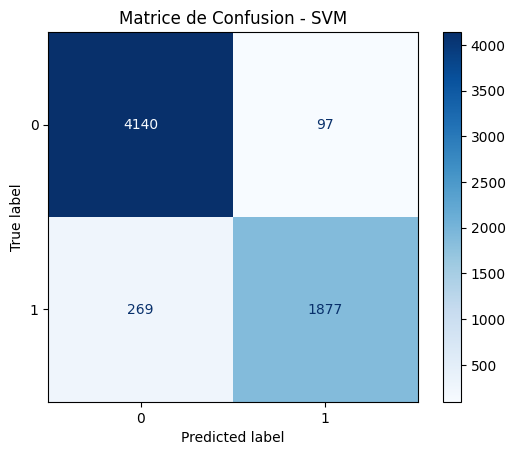

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Features et cible
features = ['CDSEXE', 'MTREV', 'NBENF', 'CDSITFAM', 'CDTMT', 'CDCATCL', 'AGEAD', 'RANGAGEAD', 'ADH', 'RANGADH']

X_train = df_train[features]
y_train = df_train['estClientActif']
X_val = df_val[features]
y_val = df_val['estClientActif']

# Preprocessing
categorical_features = ['CDSEXE', 'CDSITFAM', 'CDTMT', 'CDCATCL', 'RANGAGEAD', 'RANGADH']
numeric_features = ['MTREV', 'NBENF', 'AGEAD', 'ADH']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# --- Modèle SVM ---
pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42))
])

pipeline_svm.fit(X_train, y_train)

# Prédictions
y_pred_svm = pipeline_svm.predict(X_val)

# --- Résultats ---
print("🔵 Résultats du modèle : SVM")
print("\nClassification Report :\n")
print(classification_report(y_val, y_pred_svm))

# Matrice de confusion
cm = confusion_matrix(y_val, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_svm.classes_)
disp.plot(cmap='Blues')
plt.title('Matrice de Confusion - SVM')
plt.show()

### Raffinage SVM

In [ ]:
from sklearn.metrics import classification_report

# entraîner et évaluer SVM avec un C donné
def entrainer_svm(c_value):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(kernel='linear', C=c_value, random_state=42))
    ])
    pipeline.fit(X_train, y_train)
    y_pred_val = pipeline.predict(X_val)
    print(f"\n🔵 Résultats Validation pour SVM avec C = {c_value}")
    print(classification_report(y_val, y_pred_val))
    return pipeline

# Tester plusieurs valeurs de C
model_c01 = entrainer_svm(0.1)
model_c10 = entrainer_svm(10)


🔵 Résultats Validation pour SVM avec C = 0.1
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4237
           1       0.96      0.84      0.89      2146

    accuracy                           0.93      6383
   macro avg       0.94      0.91      0.92      6383
weighted avg       0.93      0.93      0.93      6383


🔵 Résultats Validation pour SVM avec C = 10
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4237
           1       0.95      0.84      0.89      2146

    accuracy                           0.93      6383
   macro avg       0.94      0.91      0.92      6383
weighted avg       0.93      0.93      0.93      6383



## 5) Modèle K-NN

🔵 Résultats du modèle : k-NN avec k = 5

Classification Report :

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      4237
           1       0.94      0.85      0.89      2146

    accuracy                           0.93      6383
   macro avg       0.93      0.91      0.92      6383
weighted avg       0.93      0.93      0.93      6383



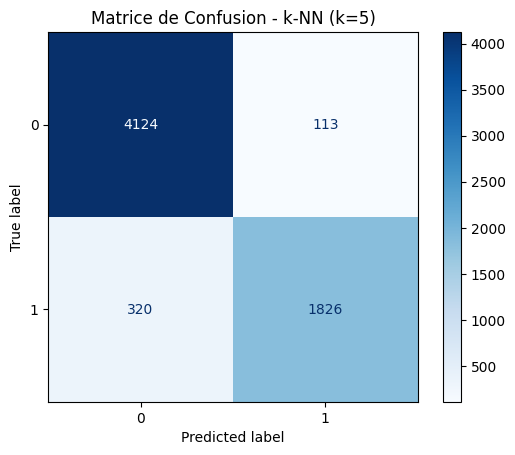

🔵 Résultats du modèle : k-NN avec k = 10

Classification Report :

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4237
           1       0.95      0.82      0.88      2146

    accuracy                           0.93      6383
   macro avg       0.94      0.90      0.92      6383
weighted avg       0.93      0.93      0.93      6383



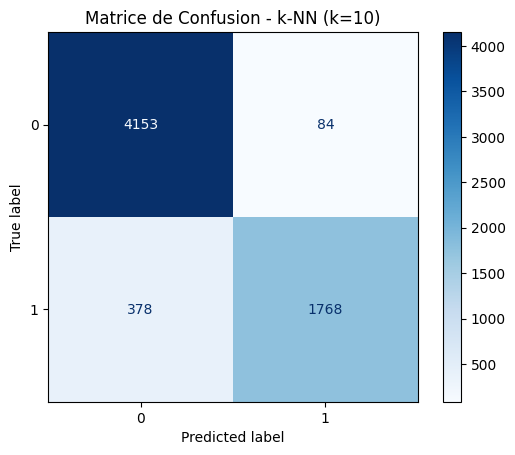

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# tester k-NN avec différentes valeurs de k
def tester_knn(k_value):
    pipeline_knn = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(n_neighbors=k_value))
    ])
    
    pipeline_knn.fit(X_train, y_train)
    y_pred_knn = pipeline_knn.predict(X_val)
    
    # Résultats
    print(f"🔵 Résultats du modèle : k-NN avec k = {k_value}")
    print("\nClassification Report :\n")
    print(classification_report(y_val, y_pred_knn))
    
    # Matrice de confusion
    cm = confusion_matrix(y_val, y_pred_knn)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_knn.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Matrice de Confusion - k-NN (k={k_value})')
    plt.show()
    
    return pipeline_knn

# Tester plusieurs k
model_knn5 = tester_knn(5)
model_knn10 = tester_knn(10)

## 6) Modèle Naive Bayes

🔵 Résultats du modèle : Naive Bayes

Classification Report :

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      4237
           1       0.88      0.85      0.87      2146

    accuracy                           0.91      6383
   macro avg       0.91      0.90      0.90      6383
weighted avg       0.91      0.91      0.91      6383



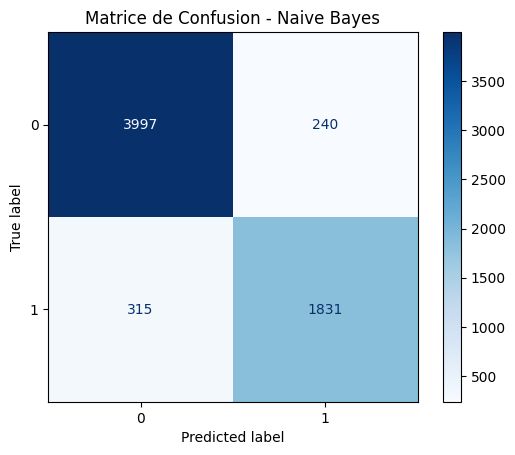

In [ ]:
from sklearn.naive_bayes import GaussianNB

# --- Transformation différente pour Naive Bayes ---
X_train_nb = preprocessor.fit_transform(X_train)
X_val_nb = preprocessor.transform(X_val)

model_nb = GaussianNB()
model_nb.fit(X_train_nb.toarray(), y_train)

# Prédictions
y_pred_nb = model_nb.predict(X_val_nb.toarray())

# --- Résultats ---
print("🔵 Résultats du modèle : Naive Bayes")
print("\nClassification Report :\n")
print(classification_report(y_val, y_pred_nb))

# Matrice de confusion
cm = confusion_matrix(y_val, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_nb.classes_)
disp.plot(cmap='Blues')
plt.title('Matrice de Confusion - Naive Bayes')
plt.show()

## 7) Modèle Random Forest 

🔵 Résultats du modèle : Random Forest

Classification Report :

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      4237
           1       0.93      0.87      0.90      2146

    accuracy                           0.93      6383
   macro avg       0.93      0.92      0.93      6383
weighted avg       0.93      0.93      0.93      6383



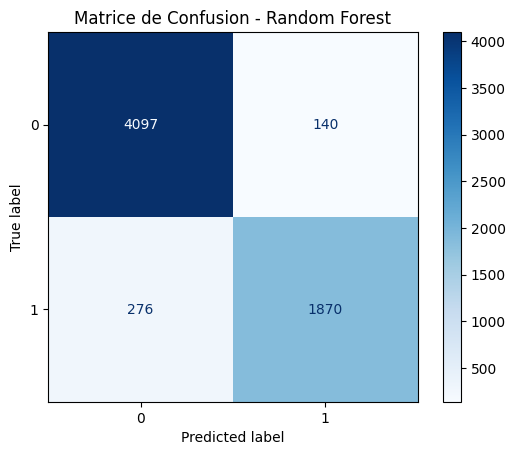

In [24]:
from sklearn.ensemble import RandomForestClassifier

# --- Modèle Random Forest ---
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_rf.fit(X_train, y_train)

# Prédictions
y_pred_rf = pipeline_rf.predict(X_val)

# --- Résultats ---
print("🔵 Résultats du modèle : Random Forest")
print("\nClassification Report :\n")
print(classification_report(y_val, y_pred_rf))

# Matrice de confusion
cm = confusion_matrix(y_val, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_rf.classes_)
disp.plot(cmap='Blues')
plt.title('Matrice de Confusion - Random Forest')
plt.show()


### Importances des features (Random forest)

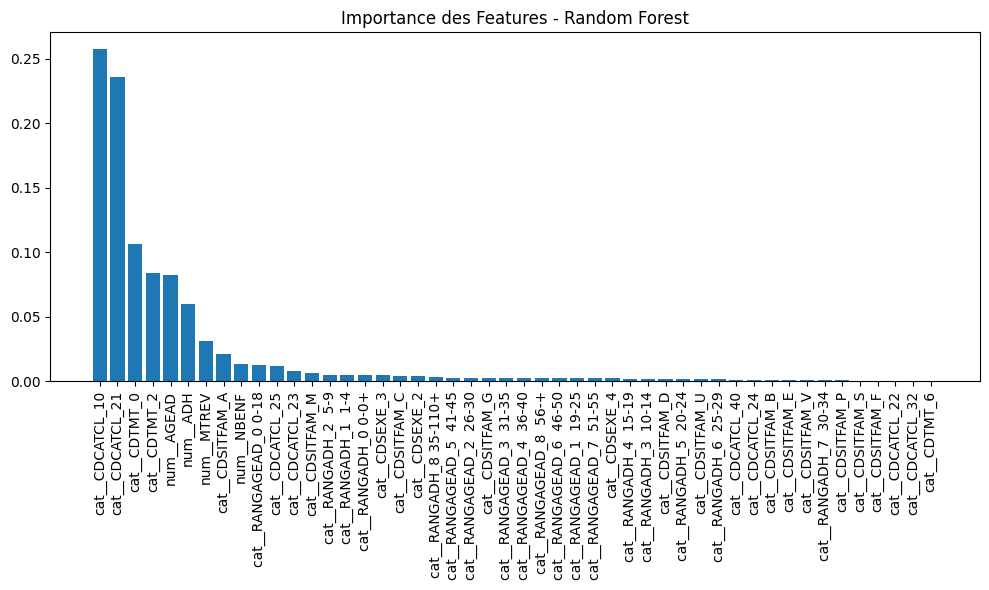

In [25]:
import numpy as np

# Extraire les importances des features
importances = pipeline_rf.named_steps['classifier'].feature_importances_

# Récupérer les noms après transformation
feature_names = pipeline_rf.named_steps['preprocessor'].get_feature_names_out()

# Tri décroissant
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Importance des Features - Random Forest")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()


## 8) Test Sur le modèle le plus performant (SVM)

🔵 Résultats du modèle SVM sur Test

Classification Report :

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4237
           1       0.95      0.87      0.91      2147

    accuracy                           0.94      6384
   macro avg       0.94      0.93      0.93      6384
weighted avg       0.94      0.94      0.94      6384



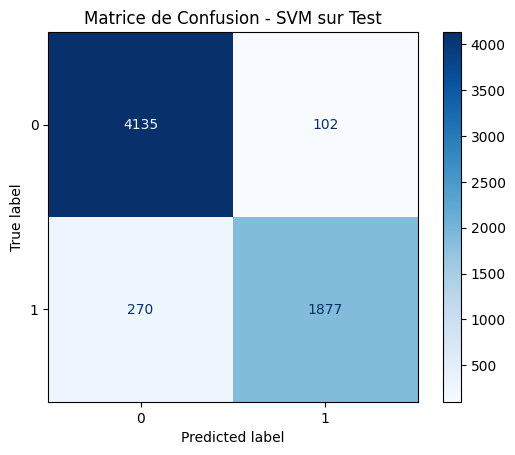

In [ ]:
# --- Préparation des données test ---
X_test = df_test[features]
y_test = df_test['estClientActif']

# --- Prédiction sur test ---
y_pred_test_svm = pipeline_svm.predict(X_test)

# --- Évaluation finale ---
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("🔵 Résultats du modèle SVM sur Test")
print("\nClassification Report :\n")
print(classification_report(y_test, y_pred_test_svm))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_test_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_svm.classes_)
disp.plot(cmap='Blues')
plt.title('Matrice de Confusion - SVM sur Test')
plt.show()